In [0]:
from PIL import Image
import torch
import torch.optim as optim
import torchvision as tv
import torch.utils.data as tud
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import random
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio
import time

from tqdm.auto import tqdm

In [0]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [0]:
def time_diff(end_time, start_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [0]:
class ZSSRDataset(tud.Dataset):
    '''TODO
    Add following options:
        - backprojection
        - downscale kernel
    '''
    def __init__(self, IMG_PATH, GT_IMG_PATH=None, sr_factor=2, crop_size = 64, 
                 transforms=None, add_noise=True, only_y=False):
        super(ZSSRDataset, self).__init__()
        
        self.img = Image.open(IMG_PATH)
        if GT_IMG_PATH:
            self.gt = Image.open(GT_IMG_PATH)
        else:
            self.gt = None
        self.interpolated = self.img.resize((self.gt.size[0], self.gt.size[1]),
                                      Image.BICUBIC)
            
        self.srf = sr_factor
        self.transforms = transforms
        self.add_noise = add_noise
        
        self.crop_size = crop_size
        self.only_y = only_y
        self.factors = self.calculate_intermediate_sr()
        self.hr_lr_pairs = self.generate_hr_lr_pairs()
        
    def __len__(self):
        return len(self.hr_lr_pairs)
    
    def __getitem__(self, idx):
        return self.hr_lr_pairs[idx]
        
    def get_images(self):
        return (self.gt, self.img, self.interpolated)
    
    def generate_hr_lr_pairs(self):
        hr_lr_pairs = []

        # # DGB
        # self.factors = [1]
        for srf in self.factors:
            hr = self.img.resize((int(self.img.size[0] * srf), int(self.img.size[1] * srf)),
                                 Image.BICUBIC)
                                 
            # change from self.img.resize tp hr.resize
            lr = hr.resize((hr.size[0] // self.srf, hr.size[1] // self.srf),
                                Image.BICUBIC)
            # Add noise
            if self.add_noise:
                lr = self.add_noise_pil(lr)

            lr = lr.resize((hr.size[0], hr.size[1]),
                          Image.BICUBIC)

            if self.only_y:
                hr, _, _ = hr.convert('YCbCr').split()
                lr, _, _ = lr.convert('YCbCr').split()

            # Apply transforms
            if self.transforms:
                seed = np.random.randint(2147483647)
                random.seed(seed)
                hr = self.transforms(hr)
                random.seed(seed)
                lr = self.transforms(lr)
            
            hr_lr_pairs.append((hr, lr))
        return hr_lr_pairs

    def add_noise_pil(self, image):
        '''
        Args:
            image (PIL image)
        '''
        image = np.array(image)
        row, col, ch = image.shape
        NOISY_PIXELS_STD = 0.0125 * 255 # Mean pixel noise added to lr sons
        noise = np.random.randn(*image.shape) * NOISY_PIXELS_STD
        noise = noise.astype('float32')
        noisy = np.clip((image + noise), 0, 255)
        return Image.fromarray((noisy).astype(np.uint8))
    
    def calculate_intermediate_sr(self):
        ''' Generate intermediate SR factors
        Args: 
            img (PIL Image): HR Image
        Returns:
            List containing intermetidate sr factors
        '''
        factors = []
        small_dim, large_dim = min(self.img.size), max(self.img.size)
        for i in range(self.crop_size, small_dim + 1):
            new_small = i
            downscale_factor = 1.0 * new_small / small_dim
            new_large = round(large_dim * downscale_factor)
            # if new_small % self.srf == 0 and new_large % self.srf == 0:
            factors.append(downscale_factor)
        return factors

# Model

In [0]:
import torch.nn as nn
class ZSSR(nn.Module):
    def __init__(self, input_chnl = 3, chnl = 64, kernel_size = 3, num_layers=6):
        super(ZSSR, self).__init__()
        layers = [
            nn.Conv2d(input_chnl, chnl, kernel_size, padding = kernel_size // 2),
            nn.ReLU()
        ]
        for _ in range(num_layers - 2):
            layers += [
                nn.Conv2d(chnl, chnl, kernel_size, padding = kernel_size // 2),
                nn.ReLU()
            ]
        layers += [nn.Conv2d(chnl, input_chnl, kernel_size, padding = kernel_size // 2)]
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, inputs):
        return inputs + self.model(inputs)

def PSNR(y_pred, y_orig):
    return 10 * torch.log10(1 / F.mse_loss(y_pred, y_orig))

# SR

In [0]:
start_time = time.time()

name = 'I_9.jpg'
OG_IMG_PATH = './hr/' + name
LR_IMG_PATH = './lr_2/' + name

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# TODO: decreasing learining rate
LEARNING_RATE = 0.001
ONLY_Y = False

HIDDEN_LAYERS = 4
NUM_LAYERS = HIDDEN_LAYERS + 2

input_chnl = 3
if ONLY_Y:
    input_chnl = 1

model = ZSSR(input_chnl = input_chnl, num_layers=NUM_LAYERS)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)
criterion = nn.MSELoss().to(device)

In [156]:
print(model)
print("Trainable parameters: ", sum(p.numel() for p in model.parameters() if p.requires_grad))

ZSSR(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)
Trainable parameters:  151235


In [157]:
CROP_SIZE = 64
SR_FACTOR = 2
img_transform = tv.transforms.Compose([
    tv.transforms.RandomRotation(90),
    tv.transforms.RandomCrop(CROP_SIZE),
    tv.transforms.RandomHorizontalFlip(0.5),
    tv.transforms.RandomVerticalFlip(0.5),
    
    # Add Noise
    tv.transforms.ToTensor(),
    # tv.transforms.Normalize(mean=[0.5], std=[0.5]),
])
dataset = ZSSRDataset(LR_IMG_PATH, OG_IMG_PATH, transforms=img_transform, 
                      sr_factor=SR_FACTOR, crop_size=CROP_SIZE, 
                      add_noise=True, only_y=ONLY_Y)

BATCH_SIZE = 32
iterator = tud.DataLoader(dataset, shuffle=True, batch_size=BATCH_SIZE)
len(iterator), len(dataset)

(3, 75)

In [158]:
import math

TOTAL_BP = 800
EPOCHS = math.ceil(TOTAL_BP / len(iterator))

history = {'loss': [], 'psnr': []}

pbar = tqdm(total=EPOCHS)
for epoch in range(EPOCHS):
    # pbar = tqdm(total=len(iterator))
    loss = 0
    psnr = 0
    model.train()
    for y_orig, lr in iterator:
        optimizer.zero_grad()
        
        y_pred = model(lr.to(device))
        batch_loss = criterion(y_pred, y_orig.to(device))
        batch_psnr = PSNR(y_pred, y_orig.to(device))
        
        batch_loss.backward()
        optimizer.step()
        
        loss += batch_loss.item()
        psnr += batch_psnr.item()
        # pbar.update(1)
    
    loss, psnr = loss/len(iterator), psnr/len(iterator)
    history['loss'].append(loss)
    history['psnr'].append(psnr)
    pbar.update(1)
    pbar.set_postfix_str("e: {}/{} => Loss: {:.3f}, Psnr: {:.3f}". format(
             epoch, EPOCHS, loss*100, psnr))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
/usr/local/lib/python3.6/dist-packages/skimage/metrics/simple_metrics.py:160: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


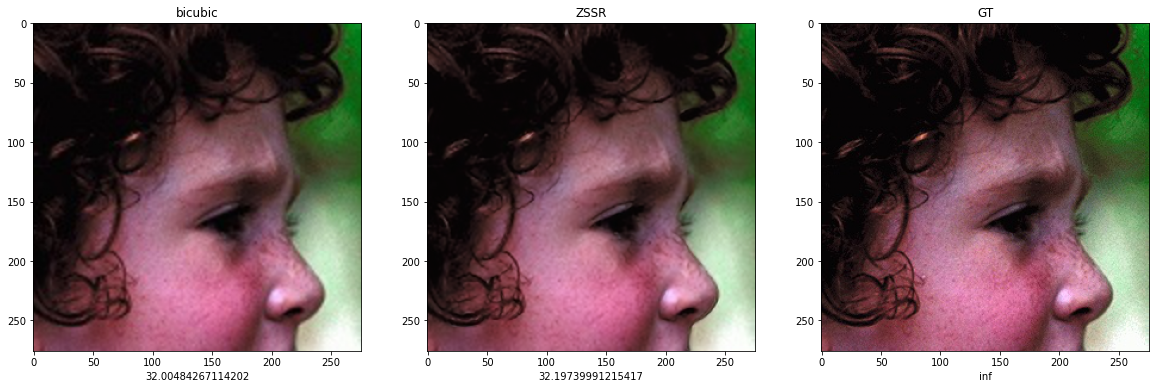

In [165]:
import cv2

og, img, interpolated = dataset.get_images()

if ONLY_Y:
    Y, Cb, Cr = interpolated.split()   

    sr_img = tv.transforms.ToTensor()(
        Y
    ).unsqueeze(0)
    sr_img = model(sr_img.to(device)).squeeze(0)
    sr_img = sr_img.detach().cpu().permute(1, 2, 0)
    sr_img = sr_img.numpy()
    sr_img = np.clip(sr_img, 0 , 1) 
    
    sr_img = Image.fromarray((sr_img[:,:,0]*255).astype(np.uint8), mode="L")
    sr_img = Image.merge('YCbCr', (sr_img, Cb, Cr))

    sr_img = np.array(sr_img)
    sr_img = np.clip(sr_img / 255, 0 , 1) 
    
else:
    sr_img = tv.transforms.ToTensor()(interpolated).unsqueeze(0)
    sr_img = model(sr_img.to(device)).squeeze(0)
    sr_img = sr_img.detach().cpu().permute(1, 2, 0)
    sr_img = torch.clamp(sr_img, min=0, max=1)
    sr_img = sr_img.numpy()
    
interpolated = np.array(interpolated)
interpolated = np.clip(interpolated / 255, 0, 1)

og = np.array(og)
og = np.clip(og / 255, 0, 1)


if og.shape[2] > 3:
    og = og[:, :, :3]
    
fig, axes = plt.subplots(1, 3, figsize=(20, 10))
im = [interpolated, sr_img, og]
title = ["bicubic", "ZSSR", "GT"]
for i, ax in enumerate(axes):
    ax.set_title(title[i])
        
    ax.set_xlabel(peak_signal_noise_ratio(im[i], im[2]))
    ax.imshow(im[i])

plt.savefig('./results/res_' + name.split(".")[0] + '_ep_' + str(EPOCHS) + '_x' + str(SR_FACTOR))

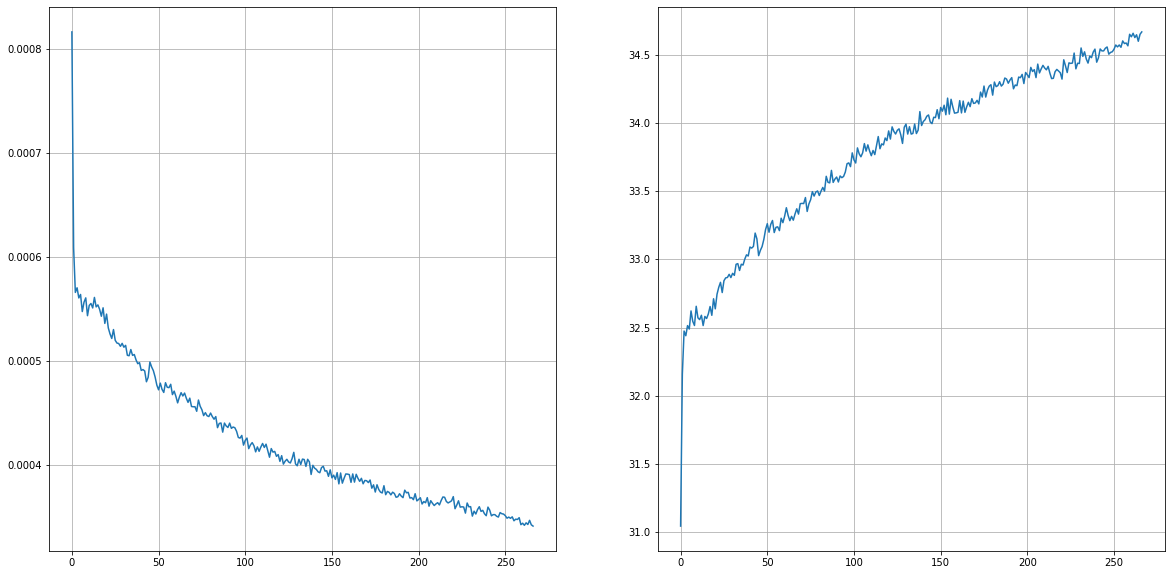

In [160]:
(fig, axes) = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
axes[0].plot(history['loss'])
axes[0].grid('on')

axes[1].plot(history['psnr'])
axes[1].grid('on')

In [161]:
end_time = time.time()
print(time_diff(end_time, start_time))

(1, 29)
